In [1]:
#!pip -q install timesfm

In [2]:
import timesfm

2024-10-05 02:33:05.968405: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
import pandas as pd
data=pd.read_csv('Electric_Production.csv')
data.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [4]:
data['DATE']=pd.to_datetime(data['DATE'])
data.head()

,DATE,IPG2211A2N
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


In [5]:
df = pd.DataFrame({'unique_id':[1]*len(data),'ds': data["DATE"], "y":data['IPG2211A2N']})
df.head(2)

,unique_id,ds,y
0,1,1985-01-01,72.5052
1,1,1985-02-01,70.6720


In [6]:
len(df)

397

In [7]:
split_idx = int(len(df) * 0.94)
train_df = df[:split_idx]
test_df = df[split_idx:]
print(train_df.shape, test_df.shape)

(373, 3) (24, 3)


In [9]:
tfm = timesfm.TimesFm(
   context_len=512,       # Length of the context window for the model
   horizon_len=24,        # Forecasting horizon length
   input_patch_len=32,    # Length of input patches
   output_patch_len=128,  # Length of output patches
   num_layers=20,
   model_dims=1280,
   backend="cpu",
)

In [10]:
# Load the pretrained model checkpoint
tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Constructing model weights.


Constructed model weights in 5.99 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 7.31 seconds.
Jitting decoding.
Jitted decoding in 42.93 seconds.


In [11]:


# Forecasting the values using the TimesFM model
timesfm_forecast = tfm.forecast_on_df(
   inputs=train_df,       # Input training data for training
   freq="MS",             # Frequency of the time-series data
   value_name="y",        # Name of the column containing the values to be forecasted
   num_jobs=-1,           # Set to -1 to use all available cores
)
timesfm_forecast.head()



Processing dataframe with multiple processes.


2024-10-05 02:35:18.825892: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Finished preprocessing dataframe.
Finished forecasting.


,unique_id,ds,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
0,1,2016-02-01,111.178429,108.236176,109.313026,109.819794,110.420387,111.178429,111.591827,112.050224,112.663704,113.859352
1,1,2016-03-01,101.570976,97.993591,99.440308,100.508064,101.124298,101.570976,102.404068,103.154457,103.849922,105.333916
2,1,2016-04-01,88.066978,84.002594,85.532089,86.320854,87.271309,88.066978,88.690407,89.401901,90.261131,91.849831
3,1,2016-05-01,90.558311,86.627449,88.050682,89.091095,89.706398,90.558311,91.359253,92.277588,93.223053,94.921417
4,1,2016-06-01,103.427704,99.636948,100.993088,101.951607,102.715332,103.427704,103.990051,105.233307,106.165039,107.505127


In [12]:
timesfm_forecast = timesfm_forecast[["ds","timesfm"]]
timesfm_forecast.head()

,ds,timesfm
0,2016-02-01,111.178429
1,2016-03-01,101.570976
2,2016-04-01,88.066978
3,2016-05-01,90.558311
4,2016-06-01,103.427704


In [13]:
import numpy as np

def mse(y_pred, y_true):
  y_pred = np.array(y_pred)
  y_true = np.array(y_true)
  return np.mean(np.square(y_pred - y_true))

def mae(y_pred, y_true):
  y_pred = np.array(y_pred)
  y_true = np.array(y_true)
  return np.mean(np.abs(y_pred - y_true))

def rmse(y_pred, y_true):
  y_pred = np.array(y_pred)
  y_true = np.array(y_true)
  return np.sqrt(np.mean((y_true - y_pred)**2))





In [14]:
len(timesfm_forecast['timesfm']), len(test_df['y'])

(24, 24)

In [15]:
print(f"Mean Absolute Error (MAE): {mae(timesfm_forecast['timesfm'], test_df['y'])}")
print(f"Mean Squared Error (MSE): {mse(timesfm_forecast['timesfm'], test_df['y'])}")
print(f"Root Mean Squared Error (RMSE): {rmse(timesfm_forecast['timesfm'], test_df['y'])}")



Mean Absolute Error (MAE): 3.0925837219238272
Mean Squared Error (MSE): 18.759551592596768
Root Mean Squared Error (RMSE): 4.3312298014070745


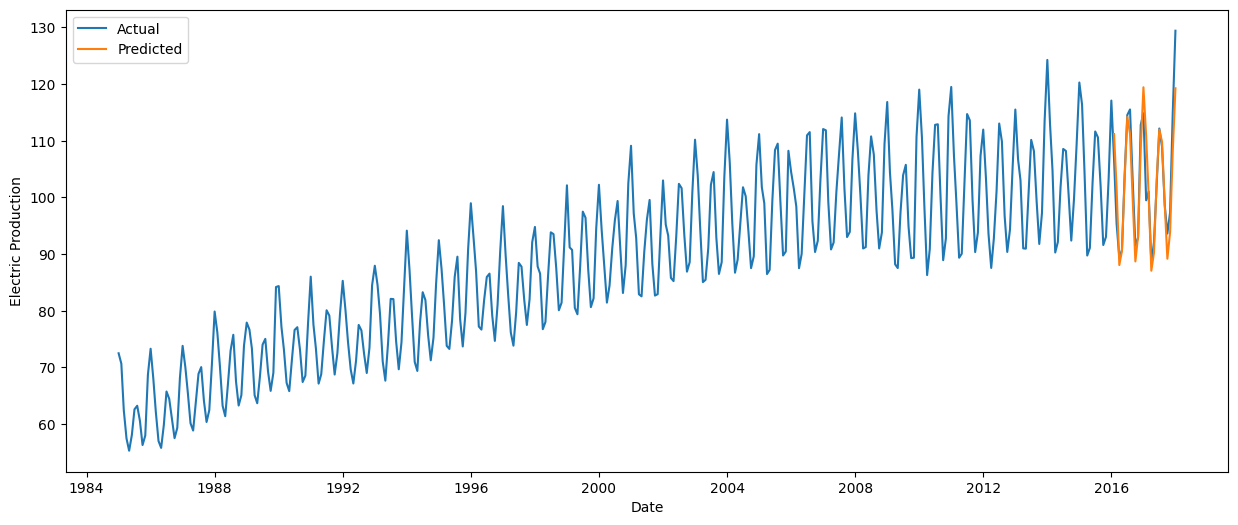

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))
plt.plot(df["ds"], df["y"], label="Actual")
plt.plot(timesfm_forecast["ds"], timesfm_forecast["timesfm"], label="Predicted")
plt.ylabel('Electric Production')
plt.xlabel('Date')
plt.legend()
plt.show()


# Covariates

Let's take a toy example of forecasting sales for a grocery store:

**Task:** Given the observed the daily sales of this week (7 days), forecast the daily sales of next week (7 days).

```
Product: ice cream
Daily_sales: [30, 30, 4, 5, 7, 8, 10]
Category: food
Base_price: 1.99
Weekday: [0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6]
Has_promotion: [Yes, Yes, No, No, No, Yes, Yes, No, No, No, No, No, No, No]
Daily_temperature: [31.0, 24.3, 19.4, 26.2, 24.6, 30.0, 31.1, 32.4, 30.9, 26.0, 25.0, 27.8, 29.5, 31.2]
```

```
Product: sunscreen
Daily_sales: [5, 7, 12, 13, 5, 6, 10]
Category: skin product
Base_price: 29.99
Weekday: [0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6]
Has_promotion: [No, No, Yes, Yes, No, No, No, Yes, Yes, Yes, Yes, Yes, Yes, Yes]
Daily_temperature: [31.0, 24.3, 19.4, 26.2, 24.6, 30.0, 31.1, 32.4, 30.9, 26.0, 25.0, 27.8, 29.5, 31.2]
```

In this example, besides the `Daily_sales`, we also have covariates `Category`, `Base_price`, `Weekday`, `Has_promotion`, `Daily_temperature`. Let's introduce some concepts:

**Static covariates** are covariates for each time series.
- In our example, `Category` is a **static categorical covariate**,
- `Base_price` is a **static numerical covariates**.

**Dynamic covariates** are covaraites for each time stamps.
- Date / time related features can be usually treated as dynamic covariates.
- In our example, `Weekday` and `Has_promotion` are **dynamic categorical covariates**.
- `Daily_temperate` is a **dynamic numerical covariate**.

**Notice:** Here we make it mandatory that the dynamic covariates need to cover both the forecasting context and horizon. For example, all dynamic covariates in the example have 14 values: the first 7 correspond to the observed 7 days, and the last 7 correspond to the next 7 days.

In [17]:
df["month"] = df['ds'].dt.strftime('%B')
df.head()

,unique_id,ds,y,month
0,1,1985-01-01,72.5052,January
1,1,1985-02-01,70.6720,February
2,1,1985-03-01,62.4502,March
3,1,1985-04-01,57.4714,April
4,1,1985-05-01,55.3151,May


In [18]:
forecast_input = [df["y"][:-24]]
len(df["y"])

397

In [19]:
dynamic_categorical_covariates = {"month": [df["month"]]}
len(df["month"])

397

In [20]:
# Call the forecast_with_covariates function
test_forecast, _ = tfm.forecast_with_covariates(
    forecast_input,
    #dynamic_numerical_covariates=dynamic_numerical_covariates,
    dynamic_categorical_covariates=dynamic_categorical_covariates,
    #static_numerical_covariates=static_numerical_covariates,
    #static_categorical_covariates=static_categorical_covariates,
    #freq=[0],
    xreg_mode="xreg + timesfm",
    ridge=0.0,
    force_on_cpu=False,
    normalize_xreg_target_per_input=True
)

test_forecast = np.array(test_forecast)  # Convert list to NumPy array

In [21]:
print(f"Mean Absolute Error (MAE): {mae(test_forecast, test_df['y'])}")
print(f"Mean Squared Error (MSE): {mse(test_forecast, test_df['y'])}")
print(f"Root Mean Squared Error (RMSE): {rmse(test_forecast, test_df['y'])}")


Mean Absolute Error (MAE): 3.4714032394409178
Mean Squared Error (MSE): 22.05345251841327
Root Mean Squared Error (RMSE): 4.696110360544487


In [22]:
forecast_input = [
    np.sin(np.linspace(0, 20, 512)),
    np.cos(np.linspace(0, 20, 512))
]
dynamic_numerical_covariates = {
    "temperature": [np.random.rand(536), np.random.rand(536)]
}
dynamic_categorical_covariates = {
    "weekday": [np.random.randint(0, 7, 536), np.random.randint(0, 7, 536)]
}
static_numerical_covariates = {
    "base_price": [10.5, 15.0]
}
static_categorical_covariates = {
    "category": ["food", "beverage"]
}


In [23]:


test_forecast, _ = tfm.forecast_with_covariates(
    forecast_input,
    dynamic_numerical_covariates=dynamic_numerical_covariates,
    dynamic_categorical_covariates=dynamic_categorical_covariates,
    static_numerical_covariates=static_numerical_covariates,
    static_categorical_covariates=static_categorical_covariates,
    freq=[0, 0],
    xreg_mode="xreg + timesfm",
    ridge=0.0,
    force_on_cpu=False,
    normalize_xreg_target_per_input=True
)

test_forecast = np.array(test_forecast)  # Convert list to NumPy array

print("Test forecast shape:", test_forecast.shape)
print("First batch test forecast first 5 values:", test_forecast[0][:5])
print("Second batch test forecast first 5 values:", test_forecast[1][:5])

Test forecast shape: (2, 24)
First batch test forecast first 5 values: [0.9351455  0.93145233 0.924177   0.87752503 0.8790826 ]
Second batch test forecast first 5 values: [0.43517342 0.3073247  0.26002192 0.3108685  0.20084164]


In [25]:
2

2